## Pneumonia Recognition Model

In [1]:
# Import packages

import warnings 
warnings.filterwarnings('ignore')

import os
import sys
import pandas as pd

In [2]:
# Define constants

DATA_DIR = 'data'
ROOT_DIR = 'working'

In [3]:
# Clone and import Mask_RCNN

!git clone https://www.github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 11.10 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [4]:
os.chdir('Mask_RCNN')

In [5]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))

from mrcnn.config import Config
from mrcnn import utils
# import mrcnn.model as modellib
# from mrcnn import visualize
# from mrcnn.model import log

In [9]:
TRAIN_DICOM_DIR = os.path.join(DATA_DIR, 'stage_2_train_images')
TEST_DICOM_DIR = os.path.join(DATA_DIR, 'stage_2_test_images')

In [10]:
# Download COCO weights

!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5
COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 alpopov alpopov 246M Dec  6 21:58 mask_rcnn_coco.h5


In [41]:
def get_dicom_dataset(dicom_dir: str) -> list:
    """Forms a dataset from a set of images
    
    Args: 
        dicom_dir (str): directory with dicom scans

    Returns:
        list: a set of scans list
    """
    dicom_fps = []
    for file_name in os.listdir(dicom_dir):
        dicom_fps.append(f'{dicom_dir}/{file_name}')
    return list(set(dicom_fps))


def parse_dataset(dicom_dir: str, annotations: pd.DataFrame) -> tuple(list, dict):
    """Parses the dataset by establishing a link between annotations and scans
    
    Args: 
        dicom_dir (str): directory with dicom scans
        annotations

    Returns:
        list: a set of scans list
    """
    image_fps = get_dicom_dataset(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for _, row in annotations.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId'] + '.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [8]:
class DetectorConfig(Config):
    NAME = 'pneumonia'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BACKBONE = 'resnet50'
    NUM_CLASSES = 2
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78
    DETECTION_NMS_THRESHOLD = 0.01
    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [9]:
class DetectorDataset(utils.Dataset):
    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [30]:
### Tests
os.chdir('/home/alpopov/pneumonia-recognition/notebooks/Mask_RCNN')
print(os.getcwd())
###

/home/alpopov/pneumonia-recognition/notebooks/Mask_RCNN


In [31]:
os.chdir(os.pardir)
os.path.isfile(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))

anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [38]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

KeyError: 'data/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm'

In [28]:
ds = pydicom.read_file(image_fps[0])
image = ds.pixel_array

In [29]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.25670.1517874466.189872
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.25670.1517874466.189872
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [30]:
ORIG_SIZE = 1024

#### Разделим данные на наборы данных для обучения и валидации

In [31]:
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)
val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

25184 1500


#### Создание и подготовка обучающего набора данных с помощью класса DetectorDataset

In [32]:
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [33]:
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    01fdfd88-7607-48b9-ba05-a36e8b6fd19b
 x                                             319
 y                                             437
 width                                         170
 height                                        289
 Target                                          1
 Name: 82, dtype: object, patientId    01fdfd88-7607-48b9-ba05-a36e8b6fd19b
 x                                             669
 y                                             449
 width                                         162
 height                                        284
 Target                                          1
 Name: 83, dtype: object]

In [34]:
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

#### Отображение случайного изображения с ограничивающими рамками

(1024, 1024, 3)
/home/ubuntu18/Access/STUDY/DT_IT_Solutions_[Corporate_Cource]/PneumoniaDetection/data/stage_2_train_images/41159056-4cb8-4937-aa38-ad56a362c673.dcm
[1 1]


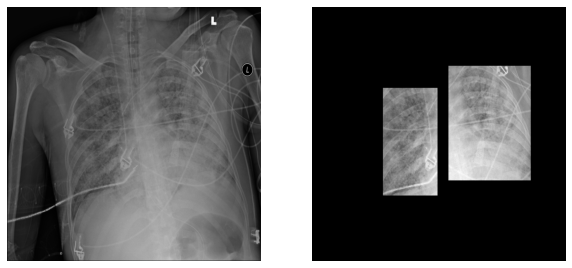

In [35]:
class_ids = [0]
while class_ids[0] == 0:
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

#### Произведем аугментацию

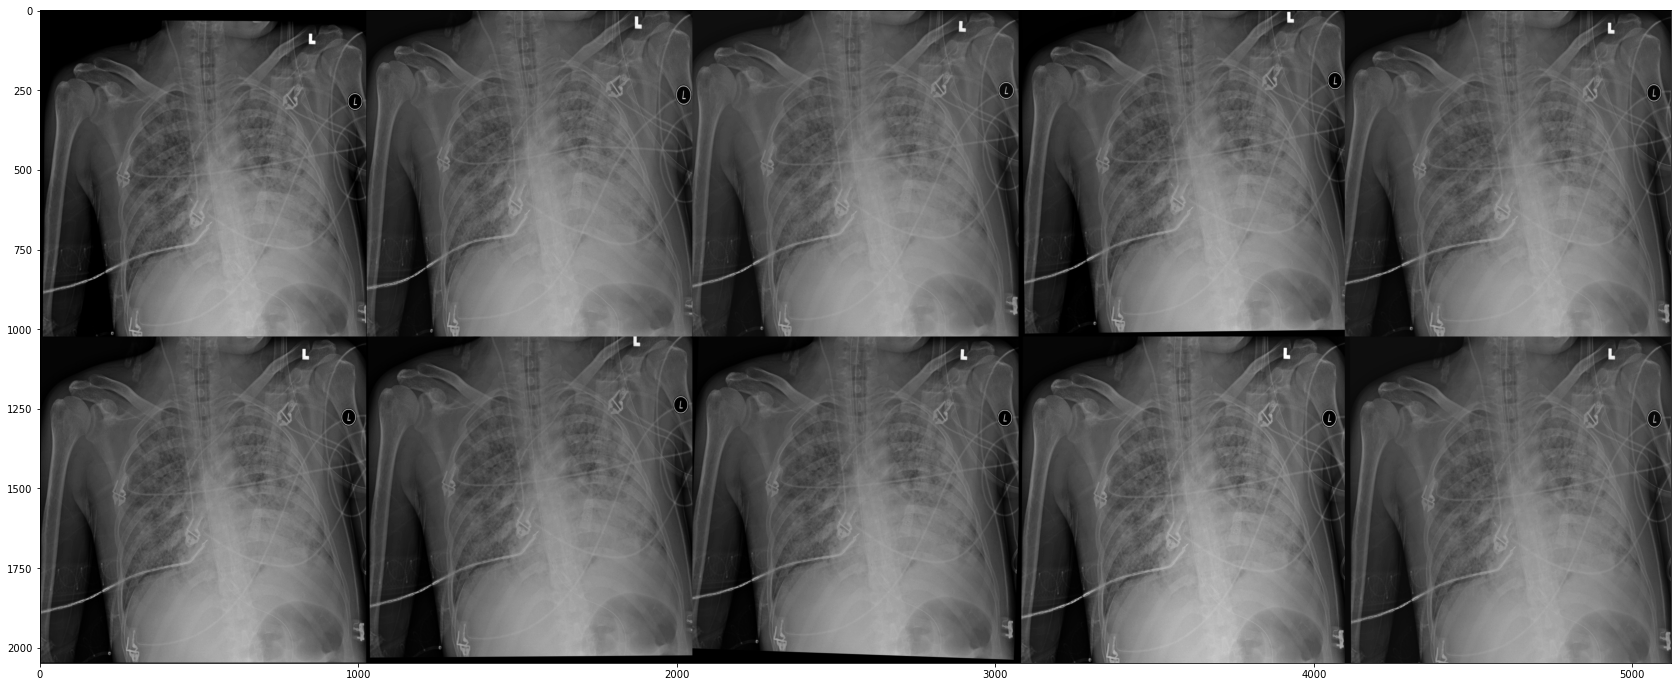

In [36]:
augmentation = iaa.Sequential([
    iaa.OneOf([ 
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

### Обучение модели

In [37]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [38]:
LEARNING_RATE = 0.012

import warnings 
warnings.filterwarnings("ignore")

In [39]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.012

Checkpoint Path: /home/ubuntu18/Access/STUDY/DT_IT_Solutions_[Corporate_Cource]/PneumoniaDetection/working/pneumonia20201217T0225/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=6,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=16,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [40]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,7.011247,0.301157,5.630207,0.139713,0.498838,0.441330,2.676605,0.080168,0.915430,0.461441,0.765637,0.453927
2,2.791700,0.081006,1.392516,0.291742,0.614608,0.411819,3.053408,0.096428,1.565497,0.330748,0.628102,0.432629


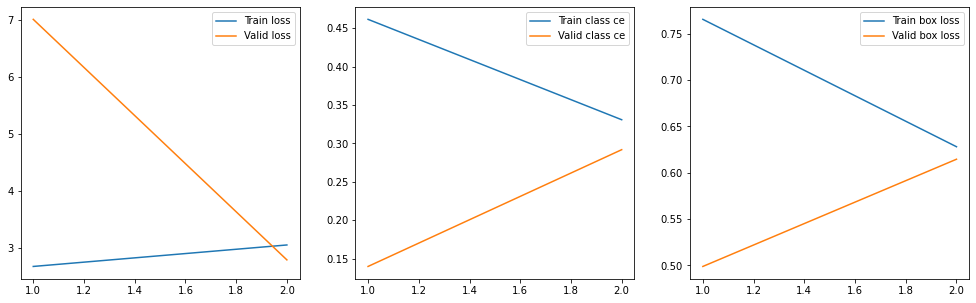

In [41]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [42]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 2 2.7917003893852232


In [43]:
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

No weight files in /home/ubuntu18/Access/STUDY/DT_IT_Solutions_[Corporate_Cource]/PneumoniaDetection/working/pneumonia20201212T2115
No weight files in /home/ubuntu18/Access/STUDY/DT_IT_Solutions_[Corporate_Cource]/PneumoniaDetection/working/pneumonia20201212T2303
No weight files in /home/ubuntu18/Access/STUDY/DT_IT_Solutions_[Corporate_Cource]/PneumoniaDetection/working/pneumonia20201213T0037
No weight files in /home/ubuntu18/Access/STUDY/DT_IT_Solutions_[Corporate_Cource]/PneumoniaDetection/working/pneumonia20201213T0042
No weight files in /home/ubuntu18/Access/STUDY/DT_IT_Solutions_[Corporate_Cource]/PneumoniaDetection/working/pneumonia20201213T0115
No weight files in /home/ubuntu18/Access/STUDY/DT_IT_Solutions_[Corporate_Cource]/PneumoniaDetection/working/pneumonia20201213T0147
No weight files in /home/ubuntu18/Access/STUDY/DT_IT_Solutions_[Corporate_Cource]/PneumoniaDetection/working/pneumonia20201213T1016
No weight files in /home/ubuntu18/Access/STUDY/DT_IT_Solutions_[Corporate_Co

In [44]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /home/ubuntu18/Access/STUDY/DT_IT_Solutions_[Corporate_Cource]/PneumoniaDetection/working/pneumonia20201217T0225/mask_rcnn_pneumonia_0002.h5
Re-starting from epoch 2


In [45]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### Проверка модели

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 



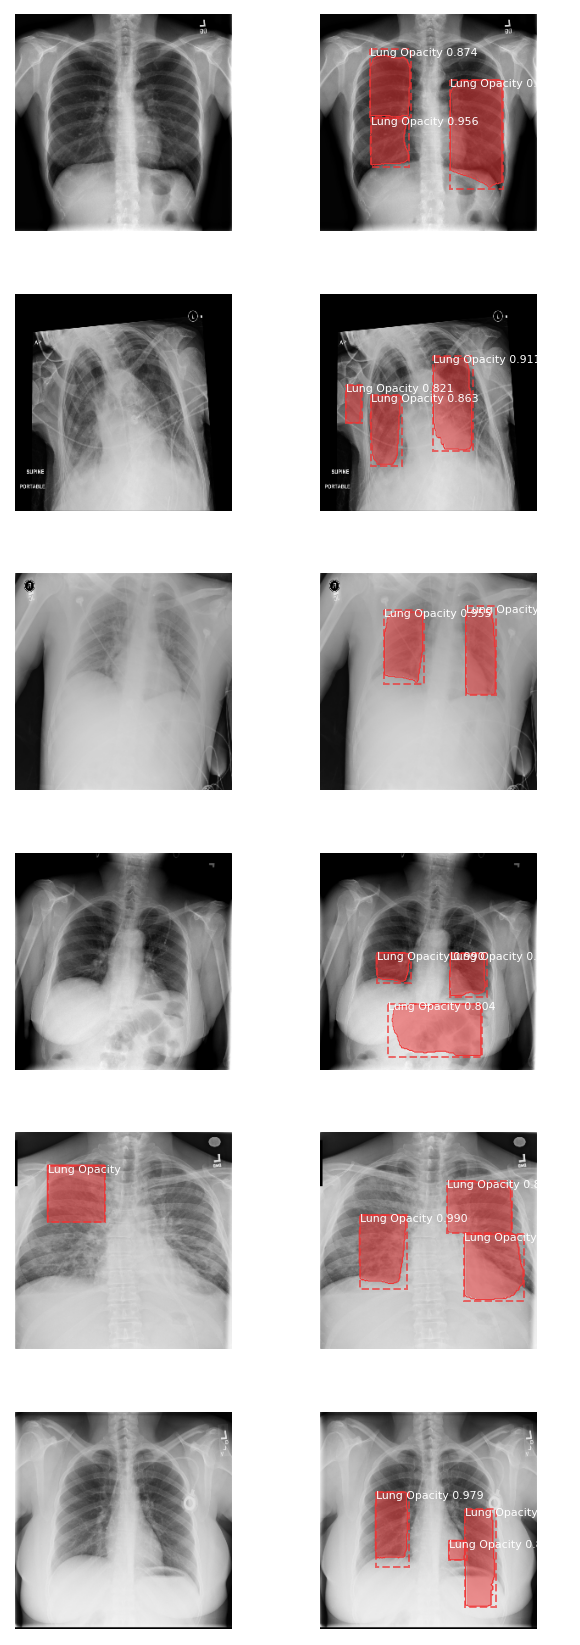

In [46]:
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image])
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [47]:
test_image_fps = get_dicom_dataset(test_dicom_dir)

In [48]:
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

#### Создадим `submission.csv`

In [49]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 3000/3000 [41:07<00:00,  1.22it/s]

/home/ubuntu18/Access/STUDY/DT_IT_Solutions_[Corporate_Cource]/PneumoniaDetection/working/submission.csv


In [50]:
output = pd.read_csv(submission_fp)
output.head(60)

,patientId,PredictionString
0,2d0f4ad5-a180-4eb9-841b-4a67224c08f7,0.97 240.0 200.0 212.0 316.0 0.96 636.0 460.0...
1,19c30ace-ee4a-4fb1-a067-a8548428996f,0.97 260.0 216.0 132.0 432.0
2,0015597f-2d69-4bc7-b642-5b5e01534676,0.98 264.0 416.0 164.0 312.0
3,2ab60eb1-862d-442c-b25d-6aafbe253571,0.97 236.0 268.0 192.0 340.0
4,2ce66821-8300-435e-9d63-5f5aad217c3d,0.97 616.0 308.0 216.0 436.0 0.96 236.0 112.0...
5,2ecb147c-cd0c-44e5-8407-d77faae38ad8,0.97 280.0 196.0 168.0 480.0 0.97 648.0 156.0...
6,0d1cf468-3791-40a7-8597-e0abb8b2d142,0.97 180.0 112.0 192.0 424.0 0.97 596.0 256.0...
7,3129f567-c659-42f8-b4e1-8a5e3827b477,0.97 608.0 332.0 188.0 424.0 0.96 196.0 452.0...
8,1ec0a41e-2a1c-4b4d-8737-06e8373c415e,0.97 256.0 440.0 172.0 328.0
9,25e3c135-1274-407c-b34d-643460fbf617,0.96 736.0 384.0 176.0 520.0


144fcb63-98e1-47a0-939f-2a4b1bf9ac07
[100  64 166 108]
x 256 y 400 h 176 w 264
[110 150 179 209]
x 600 y 440 h 236 w 276
0232e608-a7af-4af7-a104-32537c1cb26b
[ 47 175 133 209]
x 700 y 188 h 136 w 344
[ 50  74 179 116]
x 296 y 200 h 168 w 516
[133 168 201 218]
x 672 y 532 h 200 w 272
200c29e0-0373-48ea-b14c-4c811ad0f123
[ 86 162 185 230]
x 648 y 344 h 272 w 396
[101  53 179 108]
x 212 y 404 h 220 w 312
2e1220d7-1c72-4afa-881e-5380d356bca8
[ 91  82 216 129]
x 328 y 364 h 188 w 500
[ 89 178 217 233]
x 712 y 356 h 220 w 512


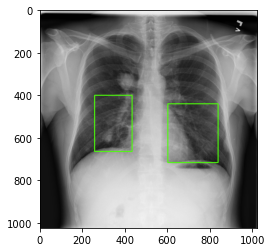

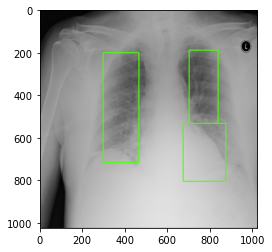

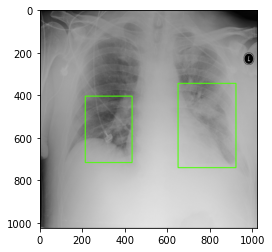

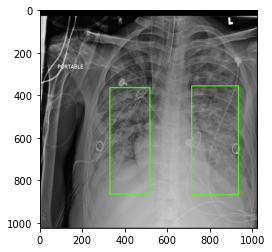

In [51]:
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)

    image = ds.pixel_array

    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]

    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()